In [91]:
import wrds, datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

pd.options.mode.chained_assignment = None  # default='warn'

conn = wrds.Connection()

Loading library list...
Done


# DATA COLLECTION

## SNP , RFR , Trading Days

In [2]:
query_start_date = '1990-01-01'

In [3]:
sp500_data = conn.raw_sql(f"""
SELECT
    caldt AS date,
    sprtrn AS snp_daily_return -- Equal-Weighted Return (includes distributions) (ewretd)
FROM
    crspq.dsp500
WHERE
    caldt >= '{query_start_date}'
ORDER BY
    caldt;
""")
sp500_data['date'] = pd.to_datetime(sp500_data['date'])

sp500_data

,date,snp_daily_return
0,1990-01-02,0.017799
1,1990-01-03,-0.002586
2,1990-01-04,-0.008613
3,1990-01-05,-0.009756
4,1990-01-08,0.004514
...,...,...
8748,2024-09-24,0.002511
8749,2024-09-25,-0.001861
8750,2024-09-26,0.004039
8751,2024-09-27,-0.001253


In [4]:
risk_free_data = conn.raw_sql(f'''
    SELECT
        date,
        rf AS daily_rf_rate -- One Month Treasury Bill Rate (daily)
    FROM
        ff.factors_daily
    WHERE
        date >= '{query_start_date}'
''')

risk_free_data['date'] = pd.to_datetime(risk_free_data['date'])

risk_free_data

,date,daily_rf_rate
0,1990-01-02,0.00026
1,1990-01-03,0.00026
2,1990-01-04,0.00026
3,1990-01-05,0.00026
4,1990-01-08,0.00026
...,...,...
8771,2024-10-25,0.00017
8772,2024-10-28,0.00017
8773,2024-10-29,0.00017
8774,2024-10-30,0.00017


In [5]:
last_trading_days = conn.raw_sql(f'''
SELECT DISTINCT
    MAX(date) AS last_trade_date
FROM crsp.dsf
WHERE date >= '{query_start_date}'
GROUP BY DATE_TRUNC('month', date)
ORDER BY last_trade_date
''')

last_trading_days['last_trade_date'] = pd.to_datetime(last_trading_days['last_trade_date'])
last_trading_days['month'] = last_trading_days['last_trade_date'].dt.month
last_trading_days['year'] = last_trading_days['last_trade_date'].dt.year
last_trading_day_mapping = last_trading_days.set_index(['year', 'month'])['last_trade_date'].to_dict()

In [6]:
last_trading_days

,last_trade_date,month,year
0,1990-01-31,1,1990
1,1990-02-28,2,1990
2,1990-03-30,3,1990
3,1990-04-30,4,1990
4,1990-05-31,5,1990
...,...,...,...
403,2023-08-31,8,2023
404,2023-09-29,9,2023
405,2023-10-31,10,2023
406,2023-11-30,11,2023


## Query Company Data

In [8]:
def get_company_financials(gvkey):
    company_fin_data = conn.raw_sql(f'''
    SELECT
        datadate AS date,
        gvkey AS gvkey,
        rdq AS reporting_date, -- Date of which information was reported
        atq AS total_assets,  -- Total Assets
        chq AS cash_holdings,  -- Cash and Short-Term Investments
        dlttq + dlcq AS total_debt,  -- Total Debt (long-term + short-term debt)
        ibq AS earnings,  -- Earnings before extraordinary items
        xrdq AS rd_expense,  -- R&D expense
        dvpq AS dividends_paid,  -- Dividends paid
        xintq AS interest_expense  -- Interest expense
    FROM
        comp.fundq
    WHERE
        gvkey = '{gvkey}'
        AND datadate >= '{query_start_date}'  -- Ensure data is after the link start date
    ''')

    if company_fin_data.empty:
        print(f"We could not pull {gvkey} company financial data, it will be skipped.")
        return company_fin_data
    
    # Convert columns to datetime
    company_fin_data['date'] = pd.to_datetime(company_fin_data['date'])
    company_fin_data['reporting_date'] = pd.to_datetime(company_fin_data['reporting_date'])
    
    # Replace NaN in specified columns with 0
    company_fin_data['rd_expense'] = company_fin_data['rd_expense'].fillna(0)
    company_fin_data['dividends_paid'] = company_fin_data['dividends_paid'].fillna(0)
    company_fin_data['interest_expense'] = company_fin_data['interest_expense'].fillna(0)
    company_fin_data['total_debt'] = company_fin_data['total_debt'].fillna(0)
    
    empty = company_fin_data.empty
    
    # Remove rows where cash_holdings is NaN
    company_fin_data = company_fin_data.dropna(subset=['cash_holdings'])

    if (not empty) and company_fin_data.empty:
        print(f"{gvkey} company had all NaN cash holdings")
    
    return company_fin_data

In [9]:
def make_PiT_ffill(company_fin_data):

    temp = company_fin_data.copy()
    
    #company_fin_data['month_start'] = company_fin_data['date'] - pd.offsets.MonthBegin()
    #company_fin_data['month_end'] = company_fin_data['date']

    temp['reporting_date'] = pd.to_datetime(temp['reporting_date']) + pd.Timedelta(days=1)
    temp['month'] = temp['reporting_date'].dt.month
    temp['year'] = temp['reporting_date'].dt.year
    
    temp['EOM_trade_date'] = temp.apply(
        lambda row: last_trading_day_mapping.get((row['year'], row['month'])),
        axis=1
    )
    temp.drop(columns=['date','month','year','reporting_date'], axis=1, inplace=True)
    temp.rename(columns={'EOM_trade_date':'date'}, inplace=True)
    temp = temp[temp.columns[-1:].append(temp.columns[:-1])]
    temp['date'] = pd.to_datetime(temp['date'])

    start_date = temp['date'].min()
    end_date = temp['date'].max()

    if pd.isnull(start_date) or pd.isnull(end_date): # return empty tables for companies that have broken data
        print("Date Error for GVKEY: ", temp['gvkey'][0])
        return pd.DataFrame({"date":[]})

    all_months = pd.date_range(start=start_date, end=end_date, freq='ME')
    full_range_df = pd.DataFrame({'date': all_months})

    temp = pd.merge(full_range_df, temp, on='date', how='left')

    temp = temp.ffill()

    temp['month_start'] = temp['date'] - pd.offsets.MonthBegin()
    temp['month_end'] = temp['date']

    return temp

In [10]:
def get_prices(permno):
    company_stock_prcs = conn.raw_sql(f'''
    SELECT
        permno,
        date,
        ret AS taken_stock_return,
        prc AS stock_price,
        ABS(prc * shrout) AS market_cap  -- Market cap
    FROM
        crsp.dsf
    WHERE
        permno = {permno}
    ''')
    
    company_stock_prcs['date'] = pd.to_datetime(company_stock_prcs['date'])

    return company_stock_prcs

In [11]:
def get_comp_data(permno, gvkey):
    # Load financial data and stock price data
    company_financials = get_company_financials(gvkey)

    if company_financials.empty:
        return company_financials
    
    company_fin_data = make_PiT_ffill(company_financials)
    company_stock_prcs = get_prices(permno)

    # Calculate monthly cumulative return using taken_stock_return
    def calculate_monthly_cumulative_returns(fin_data, stock_data):
        monthly_returns = []
        for _, row in fin_data.iterrows():
            # Filter stock data for the current month's start and end dates
            mask = (stock_data['date'] >= row['month_start']) & (stock_data['date'] <= row['month_end'])
            relevant_data = stock_data.loc[mask]

            # Compute cumulative return: (1 + taken_stock_return).prod() - 1
            if not relevant_data.empty:
                cumulative_return = (1 + relevant_data['taken_stock_return']).prod() - 1
            else:
                cumulative_return = None  # No data for this month
            monthly_returns.append(cumulative_return)
        return monthly_returns

    # Compute monthly cumulative returns
    company_fin_data['stock_return'] = calculate_monthly_cumulative_returns(company_fin_data, company_stock_prcs)

    # Merge the financial data with stock data for other columns if necessary
    company = pd.merge(company_fin_data, company_stock_prcs, on='date', how='left').interpolate().ffill()
    # drop taken_stock_return column
    company.drop(columns=['taken_stock_return'], inplace=True)

    return company


# Calculate Cash Hedged Returns

In [12]:
def calculate_b_it(company):
    data = company.copy()
    data['market_cap_t_minus_1'] = data['market_cap'].shift() # paper uses M_{t-1} for the denoms
    data['leverage'] = data['total_debt'] / (data['total_debt'] + data['market_cap'])
    
    # Y VALUES
    data['r_minus_R'] = data['stock_return'] - data['rf_rate']
    
    # REGRESSION VARIABLES
    data['gamma_1'] = (data['cash_holdings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_2'] = (data['earnings'].diff()) / data['market_cap_t_minus_1']
    data['gamma_3'] = ((data['total_assets'] - data['cash_holdings']).diff()) / data['market_cap_t_minus_1']
    data['gamma_4'] = (data['rd_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_5'] = (data['interest_expense'].diff()) / data['market_cap_t_minus_1']
    data['gamma_6'] = (data['dividends_paid'].diff()) / data['market_cap_t_minus_1']
    data['gamma_7']= data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1']
    data['gamma_8'] = data['leverage']
    data['gamma_9'] = (data['total_debt'].diff() + data['market_cap_t_minus_1'].diff()) / (data['total_debt'].shift() + data['market_cap_t_minus_1'].shift())
    data['gamma_10'] = (data['market_cap_t_minus_1'] * (data['cash_holdings'].diff())) / (data['market_cap'] ** 2)
    data['gamma_11'] = (data['leverage'] * (data['cash_holdings'].diff())) / data['market_cap']
    
    data = data.dropna()
    
    y = data['r_minus_R']
    X = data[['gamma_1', 'gamma_2', 'gamma_3', 'gamma_4', 'gamma_5', 'gamma_6', 'gamma_7', 'gamma_8', 'gamma_9', 'gamma_10', 'gamma_11']]
    
    X = sm.add_constant(X)
    
    model = sm.OLS(y, X).fit()
    
    #print(model.summary())
    
    data['marginal_cash_value'] = (
        model.params.iloc[0] +
        (model.params.iloc[10] * (data['cash_holdings_t_minus_1'] / data['market_cap_t_minus_1'])) +
        (model.params.iloc[11] * data['leverage'])
    )
    
    data['average_cash_value'] = data['marginal_cash_value'] * data['cash_holdings']
    
    company['b_it'] = data['average_cash_value'].pct_change()  # monthly cash return

In [13]:
def calculate_e_it(company):
    company['cash_hedged_return'] = (1 / (1 - company['cash_share_weight'])) * (company['stock_return'] - (company['cash_share_weight']  * company['b_it']))

In [14]:
def winsorize(series, lower=0.01, upper=0.99):
    lower_threshold = series.quantile(lower)
    upper_threshold = series.quantile(upper)
    return series.clip(lower=lower_threshold, upper=upper_threshold)

In [15]:
def calculate_returns(company):
    company['cash_share_weight'] = (company['cash_holdings'] / company['total_assets'])
    company['cash_holdings_t_minus_1'] = company['cash_holdings'].shift()
    
    calculate_b_it(company)
    calculate_e_it(company)
    
    company['cash_hedged_return'] = winsorize(company['cash_hedged_return'])

In [16]:
def calculate_rolling_beta(stock_return, market_return, window = 65):
    rolling_cov = stock_return.rolling(window).cov(market_return)
    rolling_var = market_return.rolling(window).var()
    return rolling_cov / rolling_var

# Data Aggregation

In [17]:
def main(id_table):

    agg_fin_data = pd.DataFrame(columns=['date', 'gvkey', 'reporting_date', 'total_assets', 'cash_holdings',
        'total_debt', 'earnings', 'rd_expense', 'dividends_paid',
        'interest_expense', 'stock_price', 'stock_return', 'market_cap',
        'snp_return', 'rf_rate', 'cash_share_weight', 'cash_holdings_t_minus_1',
        'b_it', 'cash_hedged_return', 'company_beta', 'cash_hedged_beta', 'comnam'])

    # Create a mapping from permno to comnam
    comnam_mapping = id_table.set_index('permno')['comnam'].to_dict()

    permnos = id_table['permno'].to_list()
    gvkeys = id_table['gvkey'].to_list()

    for i in range(len(permnos)):

        try:
            # Try to get the company data
            company = get_comp_data(permnos[i], gvkeys[i])
            
            # If the company table is empty, skip it
            if company.empty:
                print(f'The {i}th company with permno {permnos[i]} has no data. Skipping...')
                continue
            
            company['comnam'] = comnam_mapping.get(permnos[i], 'Unknown')


            def aggregate_monthly(start_date, end_date, daily_data, column, agg_func):
                mask = (daily_data['date'] >= start_date) & (daily_data['date'] <= end_date)
                return agg_func(daily_data.loc[mask, column])
            
            company['snp_return'] = company.apply(
                lambda row: aggregate_monthly(row['month_start'], row['month_end'], sp500_data, 'snp_daily_return', 
                                            lambda x: np.prod(1 + x) - 1), axis=1
            )
            
            company['rf_rate'] = company.apply(
                lambda row: aggregate_monthly(row['month_start'], row['month_end'], risk_free_data, 'daily_rf_rate', 
                                            lambda x: np.prod(1 + x) - 1), axis=1
            )
                        
            calculate_returns(company)
        
            
            company['company_beta'] = calculate_rolling_beta(company['stock_return'], company['snp_return'])
            company['cash_hedged_beta'] = calculate_rolling_beta(company['cash_hedged_return'], company['snp_return'])
            
            
            if not agg_fin_data.empty:
                agg_fin_data = pd.concat([agg_fin_data, company], ignore_index=True)
            else:
                agg_fin_data = company
        
        except Exception as e:
            # Catch any errors, log the permno and the error, then skip
            print(f"Error with permno {permnos[i]}: {e}. Skipping...")
            continue
        
    agg_fin_data = agg_fin_data.sort_values(by=['comnam', 'date']).reset_index(drop=True)

    agg_fin_data = agg_fin_data[['date', 'comnam', 'gvkey', 'permno', 'stock_price', 'stock_return', 'b_it' ,'cash_hedged_return', 'snp_return', 'rf_rate', 'company_beta', 'cash_hedged_beta', 'cash_holdings_t_minus_1']].dropna()
    
    return agg_fin_data.reset_index(drop=True)


# Company Selection and Collecting Their Data

In [21]:
query = """
SELECT *
FROM (
    SELECT DISTINCT ON (a.permno)
        a.permno, 
        a.permco, 
        a.cusip, 
        a.comnam, 
        a.namedt,
        a.nameenddt,
        a.end_date, 
        a.st_date,
        a.siccd
    FROM crsp.stocknames a
    WHERE a.hexcd IN (3) and a.st_date >= '1985-01-01' and a.end_date >= '2000-01-01' and (a.siccd < 6000 or a.siccd > 6799)
    ORDER BY a.permno, a.end_date DESC
) subquery
ORDER BY end_date DESC;

"""

ids = conn.raw_sql(query)
permnos = ids['permno'].to_list()

def get_gvkey(permno):
    link = conn.raw_sql(f'''
    SELECT *
    FROM crsp.ccmxpf_linktable
    WHERE lpermno = {permno};
    ''')
    if link.empty:
        return None
    else:
        return link['gvkey'][0]

gvkeys = [get_gvkey(permno) for permno in permnos]
# remove None values
# gvkeys = [x for x in gvkeys if x is not None]

# Remove the rows whose permno given to the function get_gvkey returns None

ids['gvkey'] = gvkeys

#assert(len(gvkeys) == len(permnos))
print(f'There are {len(gvkeys)} companies in the list.')

# only take permno and comnam and gvkey
#ids = ids[['permno', 'comnam', 'gvkey']]
ids

# save ids to csv
ids.to_csv('ids.csv', index=False)

There are 8393 companies in the list.


## Running the data collection function

In [23]:
out = main(ids) # input is any table with [permno, gvkey, comnam]

out

# save output to csv
out.to_csv('zero_filling_large_universe_presentation_code.csv', index=False)

We could not pull 038071 company financial data, it will be skipped.
The 10th company with permno 21011 has no data. Skipping...
Error with permno 21018: 0. Skipping...
Error with permno 21019: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 21023: 0. Skipping...
Error with permno 21025: zero-size array to reduction operation maximum which has no identity. Skipping...
We could not pull 037964 company financial data, it will be skipped.
The 22th company with permno 21030 has no data. Skipping...
Date Error for GVKEY:  038040
The 23th company with permno 21034 has no data. Skipping...
Error with permno 21035: zero-size array to reduction operation maximum which has no identity. Skipping...
The 28th company with permno 21052 has no data. Skipping...
We could not pull 037911 company financial data, it will be skipped.
The 34th company with permno 21068 has no data. Skipping...
We could not pull 037967 company financial data, it will be sk

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


We could not pull 039268 company financial data, it will be skipped.
The 312th company with permno 22187 has no data. Skipping...
039376 company had all NaN cash holdings
The 315th company with permno 22195 has no data. Skipping...
Error with permno 22223: zero-size array to reduction operation maximum which has no identity. Skipping...
Date Error for GVKEY:  039471
The 331th company with permno 22224 has no data. Skipping...
We could not pull 038956 company financial data, it will be skipped.
The 333th company with permno 22228 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


Error with permno 22253: 0. Skipping...
We could not pull 039458 company financial data, it will be skipped.
The 347th company with permno 22257 has no data. Skipping...
We could not pull 039408 company financial data, it will be skipped.
The 357th company with permno 22271 has no data. Skipping...
We could not pull 039720 company financial data, it will be skipped.
The 360th company with permno 22279 has no data. Skipping...
025476 company had all NaN cash holdings
The 361th company with permno 22280 has no data. Skipping...
We could not pull 039574 company financial data, it will be skipped.
The 363th company with permno 22282 has no data. Skipping...
We could not pull 038223 company financial data, it will be skipped.
The 373th company with permno 22298 has no data. Skipping...
039263 company had all NaN cash holdings
The 374th company with permno 22301 has no data. Skipping...
107644 company had all NaN cash holdings
The 375th company with permno 22302 has no data. Skipping...
We c

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Error with permno 24000: 0. Skipping...
We could not pull 040593 company financial data, it will be skipped.
The 798th company with permno 24012 has no data. Skipping...
Error with permno 24068: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 24069: single positional indexer is out-of-bounds. Skipping...
We could not pull 042970 company financial data, it will be skipped.
The 807th company with permno 24070 has no data. Skipping...
We could not pull 042314 company financial data, it will be skipped.
The 808th company with permno 24071 has no data. Skipping...
Error with permno 24075: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 24083: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 24084: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 24085: zero-size array to reduction operati

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


066313 company had all NaN cash holdings
The 1060th company with permno 88183 has no data. Skipping...
011831 company had all NaN cash holdings
The 1074th company with permno 88031 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


122255 company had all NaN cash holdings
The 1115th company with permno 87078 has no data. Skipping...
011814 company had all NaN cash holdings
The 1120th company with permno 87055 has no data. Skipping...
021598 company had all NaN cash holdings
The 1161th company with permno 86165 has no data. Skipping...
Error with permno 86092: zero-size array to reduction operation maximum which has no identity. Skipping...
The 1213th company with permno 78003 has no data. Skipping...
065243 company had all NaN cash holdings
The 1218th company with permno 85293 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


061337 company had all NaN cash holdings
The 1347th company with permno 82261 has no data. Skipping...
061166 company had all NaN cash holdings
The 1351th company with permno 82163 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


184167 company had all NaN cash holdings
The 1447th company with permno 93304 has no data. Skipping...
012381 company had all NaN cash holdings
The 1449th company with permno 10258 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


183247 company had all NaN cash holdings
The 1479th company with permno 92987 has no data. Skipping...
066158 company had all NaN cash holdings
The 1486th company with permno 92878 has no data. Skipping...
180183 company had all NaN cash holdings
The 1490th company with permno 92810 has no data. Skipping...
Error with permno 10966: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 92596: zero-size array to reduction operation maximum which has no identity. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


166576 company had all NaN cash holdings
The 1638th company with permno 91161 has no data. Skipping...
187596 company had all NaN cash holdings
The 1645th company with permno 12920 has no data. Skipping...
187164 company had all NaN cash holdings
The 1661th company with permno 13278 has no data. Skipping...
181820 company had all NaN cash holdings
The 1686th company with permno 13528 has no data. Skipping...
170419 company had all NaN cash holdings
The 1687th company with permno 13534 has no data. Skipping...
017877 company had all NaN cash holdings
The 1709th company with permno 13694 has no data. Skipping...
017451 company had all NaN cash holdings
The 1738th company with permno 13877 has no data. Skipping...
Error with permno 14543: zero-size array to reduction operation maximum which has no identity. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


139705 company had all NaN cash holdings
The 1918th company with permno 14932 has no data. Skipping...
018695 company had all NaN cash holdings
The 1924th company with permno 14943 has no data. Skipping...
021633 company had all NaN cash holdings
The 1935th company with permno 15022 has no data. Skipping...
021815 company had all NaN cash holdings
The 1945th company with permno 15084 has no data. Skipping...
176561 company had all NaN cash holdings
The 1952th company with permno 15136 has no data. Skipping...
022975 company had all NaN cash holdings
The 1957th company with permno 15178 has no data. Skipping...
We could not pull 023421 company financial data, it will be skipped.
The 1965th company with permno 15267 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


025327 company had all NaN cash holdings
The 2025th company with permno 15539 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


108979 company had all NaN cash holdings
The 2057th company with permno 15840 has no data. Skipping...
187236 company had all NaN cash holdings
The 2095th company with permno 16063 has no data. Skipping...
027604 company had all NaN cash holdings
The 2101th company with permno 16097 has no data. Skipping...
027665 company had all NaN cash holdings
The 2118th company with permno 16253 has no data. Skipping...
027945 company had all NaN cash holdings
The 2124th company with permno 16285 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


029499 company had all NaN cash holdings
The 2175th company with permno 16671 has no data. Skipping...
112572 company had all NaN cash holdings
The 2182th company with permno 16703 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


031606 company had all NaN cash holdings
The 2193th company with permno 16784 has no data. Skipping...
012035 company had all NaN cash holdings
The 2208th company with permno 16828 has no data. Skipping...
027345 company had all NaN cash holdings
The 2210th company with permno 16853 has no data. Skipping...
We could not pull 314996 company financial data, it will be skipped.
The 2216th company with permno 16894 has no data. Skipping...
110979 company had all NaN cash holdings
The 2236th company with permno 16976 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


018182 company had all NaN cash holdings
The 2238th company with permno 16982 has no data. Skipping...
032619 company had all NaN cash holdings
The 2242th company with permno 16991 has no data. Skipping...
032253 company had all NaN cash holdings
The 2244th company with permno 16995 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


We could not pull 315258 company financial data, it will be skipped.
The 2259th company with permno 17110 has no data. Skipping...
We could not pull 032672 company financial data, it will be skipped.
The 2260th company with permno 17113 has no data. Skipping...
032665 company had all NaN cash holdings
The 2263th company with permno 17117 has no data. Skipping...
032698 company had all NaN cash holdings
The 2265th company with permno 17121 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


Error with permno 17147: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const       float64
gamma_1     float64
gamma_2      object
gamma_3     float64
gamma_4     float64
gamma_5     float64
gamma_6     float64
gamma_7     float64
gamma_8     float64
gamma_9     float64
gamma_10    float64
gamma_11    float64
dtype: object. The data was
Series([], Name: r_minus_R, dtype: object)
and
 Empty DataFrame
Columns: [const, gamma_1, gamma_2, gamma_3, gamma_4, gamma_5, gamma_6, gamma_7, gamma_8, gamma_9, gamma_10, gamma_11]
Index: []
before. After,
[]
[].. Skipping...
032763 company had all NaN cash holdings
The 2278th company with permno 17148 has no data. Skipping...
144122 company had all NaN cash holdings
The 2280th company with permno 17151 has no data. Skipping...
033131 company had all NaN cash holdings
The 2309th company with permno 17350 has no data. Skipping...
113978 company had all NaN cash holdings
The 2314th company 

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


033695 company had all NaN cash holdings
The 2382th company with permno 17957 has no data. Skipping...
033704 company had all NaN cash holdings
The 2388th company with permno 17970 has no data. Skipping...
033625 company had all NaN cash holdings
The 2397th company with permno 18043 has no data. Skipping...
157498 company had all NaN cash holdings
The 2402th company with permno 18052 has no data. Skipping...
034132 company had all NaN cash holdings
The 2413th company with permno 18106 has no data. Skipping...
034189 company had all NaN cash holdings
The 2414th company with permno 18108 has no data. Skipping...
018264 company had all NaN cash holdings
The 2416th company with permno 18115 has no data. Skipping...
150803 company had all NaN cash holdings
The 2430th company with permno 18191 has no data. Skipping...
We could not pull 034260 company financial data, it will be skipped.
The 2436th company with permno 18207 has no data. Skipping...
034618 company had all NaN cash holdings
The 

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


176828 company had all NaN cash holdings
The 2491th company with permno 18459 has no data. Skipping...
066355 company had all NaN cash holdings
The 2503th company with permno 18554 has no data. Skipping...
164724 company had all NaN cash holdings
The 2508th company with permno 18560 has no data. Skipping...
018385 company had all NaN cash holdings
The 2522th company with permno 18652 has no data. Skipping...
035078 company had all NaN cash holdings
The 2528th company with permno 18668 has no data. Skipping...
035101 company had all NaN cash holdings
The 2530th company with permno 18671 has no data. Skipping...
Error with permno 18776: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 18781: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 18835: zero-size array to reduction operation maximum which has no identity. Skipping...
034937 company had all NaN cash holdings
The 2559th company w

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


018434 company had all NaN cash holdings
The 2585th company with permno 18941 has no data. Skipping...
035759 company had all NaN cash holdings
The 2599th company with permno 19012 has no data. Skipping...
027111 company had all NaN cash holdings
The 2601th company with permno 19015 has no data. Skipping...
We could not pull 035895 company financial data, it will be skipped.
The 2615th company with permno 19068 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


035646 company had all NaN cash holdings
The 2642th company with permno 19185 has no data. Skipping...
We could not pull 033634 company financial data, it will be skipped.
The 2644th company with permno 19192 has no data. Skipping...
066453 company had all NaN cash holdings
The 2655th company with permno 19231 has no data. Skipping...
We could not pull 023607 company financial data, it will be skipped.
The 2656th company with permno 19232 has no data. Skipping...
178923 company had all NaN cash holdings
The 2664th company with permno 19310 has no data. Skipping...
We could not pull 184862 company financial data, it will be skipped.
The 2668th company with permno 19348 has no data. Skipping...
Error with permno 19547: zero-size array to reduction operation maximum which has no identity. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


Error with permno 19628: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 19644: single positional indexer is out-of-bounds. Skipping...
We could not pull 164053 company financial data, it will be skipped.
The 2752th company with permno 19648 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


We could not pull 036752 company financial data, it will be skipped.
The 2775th company with permno 19824 has no data. Skipping...
036633 company had all NaN cash holdings
The 2791th company with permno 19854 has no data. Skipping...
Error with permno 19955: single positional indexer is out-of-bounds. Skipping...
We could not pull 036978 company financial data, it will be skipped.
The 2829th company with permno 20137 has no data. Skipping...
We could not pull 037014 company financial data, it will be skipped.
The 2831th company with permno 20145 has no data. Skipping...
We could not pull 037065 company financial data, it will be skipped.
The 2832th company with permno 20146 has no data. Skipping...
We could not pull 180250 company financial data, it will be skipped.
The 2835th company with permno 20150 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


We could not pull 037406 company financial data, it will be skipped.
The 2838th company with permno 20155 has no data. Skipping...
We could not pull 037068 company financial data, it will be skipped.
The 2845th company with permno 20178 has no data. Skipping...
Error with permno 20181: zero-size array to reduction operation maximum which has no identity. Skipping...
We could not pull 037237 company financial data, it will be skipped.
The 2856th company with permno 20277 has no data. Skipping...
We could not pull 037236 company financial data, it will be skipped.
The 2857th company with permno 20278 has no data. Skipping...
We could not pull 037030 company financial data, it will be skipped.
The 2859th company with permno 20281 has no data. Skipping...
We could not pull 037288 company financial data, it will be skipped.
The 2860th company with permno 20282 has no data. Skipping...
We could not pull 037020 company financial data, it will be skipped.
The 2866th company with permno 20290 h

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


Error with permno 20601: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 20612: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 20638: 0. Skipping...
We could not pull 026832 company financial data, it will be skipped.
The 2958th company with permno 20639 has no data. Skipping...
115960 company had all NaN cash holdings
The 2968th company with permno 20660 has no data. Skipping...
We could not pull 037734 company financial data, it will be skipped.
The 2976th company with permno 20785 has no data. Skipping...
Error with permno 20805: 0. Skipping...
We could not pull 037816 company financial data, it will be skipped.
The 2993th company with permno 20827 has no data. Skipping...
We could not pull 037710 company financial data, it will be skipped.
The 2997th company with permno 20843 has no data. Skipping...
We could not pull 037681 company financial data, it will be skipped.
The 2998th

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


We could not pull 024028 company financial data, it will be skipped.
The 3026th company with permno 20306 has no data. Skipping...
We could not pull 039936 company financial data, it will be skipped.
The 3033th company with permno 22650 has no data. Skipping...
We could not pull 038099 company financial data, it will be skipped.
The 3040th company with permno 20831 has no data. Skipping...
We could not pull 037823 company financial data, it will be skipped.
The 3041th company with permno 20878 has no data. Skipping...
The 3042th company with permno 23418 has no data. Skipping...
We could not pull 037976 company financial data, it will be skipped.
The 3045th company with permno 21049 has no data. Skipping...
We could not pull 040514 company financial data, it will be skipped.
The 3046th company with permno 22907 has no data. Skipping...
We could not pull 274411 company financial data, it will be skipped.
The 3049th company with permno 19942 has no data. Skipping...
We could not pull 038

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


We could not pull 040072 company financial data, it will be skipped.
The 3072th company with permno 22624 has no data. Skipping...
We could not pull 038088 company financial data, it will be skipped.
The 3082th company with permno 22276 has no data. Skipping...
We could not pull 038470 company financial data, it will be skipped.
The 3084th company with permno 22901 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


Error with permno 22774: 0. Skipping...
We could not pull 037483 company financial data, it will be skipped.
The 3093th company with permno 20448 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


We could not pull 039584 company financial data, it will be skipped.
The 3100th company with permno 22309 has no data. Skipping...
We could not pull 264281 company financial data, it will be skipped.
The 3105th company with permno 19143 has no data. Skipping...
We could not pull 037039 company financial data, it will be skipped.
The 3110th company with permno 20283 has no data. Skipping...
001111 company had all NaN cash holdings
The 3111th company with permno 79678 has no data. Skipping...
We could not pull 039026 company financial data, it will be skipped.
The 3113th company with permno 22335 has no data. Skipping...
We could not pull 040253 company financial data, it will be skipped.
The 3117th company with permno 22630 has no data. Skipping...
We could not pull 039980 company financial data, it will be skipped.
The 3123th company with permno 22668 has no data. Skipping...
We could not pull 039885 company financial data, it will be skipped.
The 3124th company with permno 22579 has n

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


We could not pull 040562 company financial data, it will be skipped.
The 3257th company with permno 22914 has no data. Skipping...
We could not pull 039451 company financial data, it will be skipped.
The 3258th company with permno 22216 has no data. Skipping...
We could not pull 039947 company financial data, it will be skipped.
The 3264th company with permno 22690 has no data. Skipping...
We could not pull 039260 company financial data, it will be skipped.
The 3266th company with permno 22188 has no data. Skipping...
We could not pull 039809 company financial data, it will be skipped.
The 3267th company with permno 22572 has no data. Skipping...
We could not pull 039923 company financial data, it will be skipped.
The 3270th company with permno 22604 has no data. Skipping...
We could not pull 037912 company financial data, it will be skipped.
The 3271th company with permno 20859 has no data. Skipping...
We could not pull 039878 company financial data, it will be skipped.
The 3272th com

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


026270 company had all NaN cash holdings
The 3557th company with permno 15774 has no data. Skipping...
Error with permno 20873: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const       float64
gamma_1     float64
gamma_2     float64
gamma_3     float64
gamma_4     float64
gamma_5     float64
gamma_6     float64
gamma_7     float64
gamma_8     float64
gamma_9     float64
gamma_10    float64
gamma_11    float64
dtype: object. The data was
Series([], Name: r_minus_R, dtype: object)
and
 Empty DataFrame
Columns: [const, gamma_1, gamma_2, gamma_3, gamma_4, gamma_5, gamma_6, gamma_7, gamma_8, gamma_9, gamma_10, gamma_11]
Index: []
before. After,
[]
[].. Skipping...
We could not pull 037190 company financial data, it will be skipped.
The 3568th company with permno 20440 has no data. Skipping...
We could not pull 037535 company financial data, it will be skipped.
The 3578th company with permno 20577 has no data. Skipping...
Erro

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


Error with permno 20807: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const       float64
gamma_1     float64
gamma_2     float64
gamma_3     float64
gamma_4     float64
gamma_5     float64
gamma_6     float64
gamma_7     float64
gamma_8     float64
gamma_9     float64
gamma_10    float64
gamma_11    float64
dtype: object. The data was
Series([], Name: r_minus_R, dtype: object)
and
 Empty DataFrame
Columns: [const, gamma_1, gamma_2, gamma_3, gamma_4, gamma_5, gamma_6, gamma_7, gamma_8, gamma_9, gamma_10, gamma_11]
Index: []
before. After,
[]
[].. Skipping...
179048 company had all NaN cash holdings
The 3671th company with permno 15709 has no data. Skipping...
Error with permno 21093: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const       float64
gamma_1     float64
gamma_2     float64
gamma_3     float64
gamma_4     float64
gamma_5     float64
gamma_6   

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


Error with permno 20772: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const       float64
gamma_1     float64
gamma_2     float64
gamma_3     float64
gamma_4     float64
gamma_5     float64
gamma_6     float64
gamma_7     float64
gamma_8     float64
gamma_9     float64
gamma_10    float64
gamma_11    float64
dtype: object. The data was
Series([], Name: r_minus_R, dtype: object)
and
 Empty DataFrame
Columns: [const, gamma_1, gamma_2, gamma_3, gamma_4, gamma_5, gamma_6, gamma_7, gamma_8, gamma_9, gamma_10, gamma_11]
Index: []
before. After,
[]
[].. Skipping...
Error with permno 20778: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const       float64
gamma_1     float64
gamma_2     float64
gamma_3     float64
gamma_4     float64
gamma_5     float64
gamma_6     float64
gamma_7     float64
gamma_8     float64
gamma_9     float64
gamma_10    float64
gamma_11    f

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


023698 company had all NaN cash holdings
The 3732th company with permno 15435 has no data. Skipping...
We could not pull 037788 company financial data, it will be skipped.
The 3736th company with permno 20770 has no data. Skipping...
We could not pull 037663 company financial data, it will be skipped.
The 3741th company with permno 20771 has no data. Skipping...
We could not pull 037165 company financial data, it will be skipped.
The 3753th company with permno 20450 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


We could not pull 037078 company financial data, it will be skipped.
The 3760th company with permno 20460 has no data. Skipping...
019815 company had all NaN cash holdings
The 3762th company with permno 17798 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


We could not pull 297095 company financial data, it will be skipped.
The 3777th company with permno 17258 has no data. Skipping...
185113 company had all NaN cash holdings
The 3779th company with permno 12362 has no data. Skipping...
Error with permno 88244: zero-size array to reduction operation maximum which has no identity. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


Error with permno 19671: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const       float64
gamma_1     float64
gamma_2     float64
gamma_3     float64
gamma_4     float64
gamma_5     float64
gamma_6     float64
gamma_7     float64
gamma_8     float64
gamma_9     float64
gamma_10    float64
gamma_11    float64
dtype: object. The data was
Series([], Name: r_minus_R, dtype: object)
and
 Empty DataFrame
Columns: [const, gamma_1, gamma_2, gamma_3, gamma_4, gamma_5, gamma_6, gamma_7, gamma_8, gamma_9, gamma_10, gamma_11]
Index: []
before. After,
[]
[].. Skipping...
193855 company had all NaN cash holdings
The 3904th company with permno 13203 has no data. Skipping...
020277 company had all NaN cash holdings
The 3906th company with permno 14602 has no data. Skipping...
We could not pull 035659 company financial data, it will be skipped.
The 3916th company with permno 18906 has no data. Skipping...
We could not pull None company f

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


Error with permno 16925: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const       float64
gamma_1     float64
gamma_2     float64
gamma_3     float64
gamma_4     float64
gamma_5     float64
gamma_6     float64
gamma_7     float64
gamma_8     float64
gamma_9     float64
gamma_10    float64
gamma_11    float64
dtype: object. The data was
Series([], Name: r_minus_R, dtype: object)
and
 Empty DataFrame
Columns: [const, gamma_1, gamma_2, gamma_3, gamma_4, gamma_5, gamma_6, gamma_7, gamma_8, gamma_9, gamma_10, gamma_11]
Index: []
before. After,
[]
[].. Skipping...
186498 company had all NaN cash holdings
The 4119th company with permno 13014 has no data. Skipping...
181515 company had all NaN cash holdings
The 4129th company with permno 12498 has no data. Skipping...
We could not pull 165621 company financial data, it will be skipped.
The 4130th company with permno 90982 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


019529 company had all NaN cash holdings
The 4147th company with permno 14425 has no data. Skipping...
186344 company had all NaN cash holdings
The 4148th company with permno 12884 has no data. Skipping...
Error with permno 93396: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data). The types seen wereNone and const       float64
gamma_1     float64
gamma_2     float64
gamma_3     float64
gamma_4     float64
gamma_5     float64
gamma_6     float64
gamma_7     float64
gamma_8     float64
gamma_9     float64
gamma_10    float64
gamma_11    float64
dtype: object. The data was
Series([], Name: r_minus_R, dtype: object)
and
 Empty DataFrame
Columns: [const, gamma_1, gamma_2, gamma_3, gamma_4, gamma_5, gamma_6, gamma_7, gamma_8, gamma_9, gamma_10, gamma_11]
Index: []
before. After,
[]
[].. Skipping...
165513 company had all NaN cash holdings
The 4168th company with permno 15509 has no data. Skipping...
018247 company had all NaN cash holdings
The 4176th company 

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


Error with permno 17149: zero-size array to reduction operation maximum which has no identity. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


156421 company had all NaN cash holdings
The 4243th company with permno 16106 has no data. Skipping...
112904 company had all NaN cash holdings
The 4257th company with permno 86270 has no data. Skipping...
187549 company had all NaN cash holdings
The 4263th company with permno 13594 has no data. Skipping...
186290 company had all NaN cash holdings
The 4286th company with permno 12509 has no data. Skipping...
017707 company had all NaN cash holdings
The 4287th company with permno 13885 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


190567 company had all NaN cash holdings
The 4300th company with permno 13036 has no data. Skipping...
Error with permno 16629: single positional indexer is out-of-bounds. Skipping...
166751 company had all NaN cash holdings
The 4340th company with permno 15514 has no data. Skipping...
017709 company had all NaN cash holdings
The 4354th company with permno 13934 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


109823 company had all NaN cash holdings
The 4439th company with permno 88148 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


192458 company had all NaN cash holdings
The 4464th company with permno 14471 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


022868 company had all NaN cash holdings
The 4495th company with permno 15217 has no data. Skipping...
017388 company had all NaN cash holdings
The 4525th company with permno 14303 has no data. Skipping...
065014 company had all NaN cash holdings
The 4552th company with permno 85208 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


176475 company had all NaN cash holdings
The 4584th company with permno 13699 has no data. Skipping...
184117 company had all NaN cash holdings
The 4590th company with permno 93224 has no data. Skipping...
030012 company had all NaN cash holdings
The 4597th company with permno 80452 has no data. Skipping...
187132 company had all NaN cash holdings
The 4599th company with permno 12921 has no data. Skipping...
015149 company had all NaN cash holdings
The 4612th company with permno 13649 has no data. Skipping...
We could not pull 018117 company financial data, it will be skipped.
The 4620th company with permno 15141 has no data. Skipping...
016620 company had all NaN cash holdings
The 4621th company with permno 76020 has no data. Skipping...
163872 company had all NaN cash holdings
The 4627th company with permno 14553 has no data. Skipping...
128581 company had all NaN cash holdings
The 4640th company with permno 12967 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


185209 company had all NaN cash holdings
The 4694th company with permno 12025 has no data. Skipping...
186084 company had all NaN cash holdings
The 4713th company with permno 12688 has no data. Skipping...
184180 company had all NaN cash holdings
The 4720th company with permno 93234 has no data. Skipping...
133048 company had all NaN cash holdings
The 4742th company with permno 13754 has no data. Skipping...
185827 company had all NaN cash holdings
The 4744th company with permno 12406 has no data. Skipping...
183580 company had all NaN cash holdings
The 4757th company with permno 93235 has no data. Skipping...
017221 company had all NaN cash holdings
The 4761th company with permno 88806 has no data. Skipping...
Error with permno 77011: zero-size array to reduction operation maximum which has no identity. Skipping...
We could not pull None company financial data, it will be skipped.
The 4769th company with permno 14835 has no data. Skipping...
017057 company had all NaN cash holdings
Th

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


003500 company had all NaN cash holdings
The 4845th company with permno 87039 has no data. Skipping...
Error with permno 13882: zero-size array to reduction operation maximum which has no identity. Skipping...
174579 company had all NaN cash holdings
The 4883th company with permno 91892 has no data. Skipping...
Error with permno 12966: zero-size array to reduction operation maximum which has no identity. Skipping...
025490 company had all NaN cash holdings
The 4955th company with permno 79519 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/arman

155737 company had all NaN cash holdings
The 5082th company with permno 89863 has no data. Skipping...
062927 company had all NaN cash holdings
The 5095th company with permno 83554 has no data. Skipping...
063942 company had all NaN cash holdings
The 5101th company with permno 90727 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


109929 company had all NaN cash holdings
The 5125th company with permno 85971 has no data. Skipping...
Error with permno 13011: single positional indexer is out-of-bounds. Skipping...
Error with permno 13010: single positional indexer is out-of-bounds. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Error with permno 92422: zero-size array to reduction operation maximum which has no identity. Skipping...
121199 company had all NaN cash holdings
The 5251th company with permno 87843 has no data. Skipping...
028740 company had all NaN cash holdings
The 5302th company with permno 79365 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


003711 company had all NaN cash holdings
The 5354th company with permno 86786 has no data. Skipping...
165698 company had all NaN cash holdings
The 5357th company with permno 91091 has no data. Skipping...
We could not pull 155314 company financial data, it will be skipped.
The 5371th company with permno 89944 has no data. Skipping...
Error with permno 79251: zero-size array to reduction operation maximum which has no identity. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


061349 company had all NaN cash holdings
The 5402th company with permno 82238 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


157633 company had all NaN cash holdings
The 5446th company with permno 90025 has no data. Skipping...
108695 company had all NaN cash holdings
The 5449th company with permno 87838 has no data. Skipping...
126297 company had all NaN cash holdings
The 5456th company with permno 87392 has no data. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


The 5484th company with permno 77163 has no data. Skipping...
Error with permno 90452: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 80245: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 76845: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 78815: zero-size array to reduction operation maximum which has no identity. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4657: RuntimeWarning: invalid value encountered in add
  lerp_interpolation = asanyarray(add(a, diff_b_a * t, out=out))


Error with permno 92098: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 79528: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 86910: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 84426: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 88161: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 76706: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 12236: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 81901: zero-size array to reduction operation maximum which has no identity. Skipping...


/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Error with permno 91835: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 83499: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 88271: zero-size array to reduction operation maximum which has no identity. Skipping...
029074 company had all NaN cash holdings
The 5522th company with permno 79721 has no data. Skipping...
Error with permno 86324: zero-size array to reduction operation maximum which has no identity. Skipping...
The 5524th company with permno 75902 has no data. Skipping...
The 5525th company with permno 84529 has no data. Skipping...
The 5526th company with permno 91268 has no data. Skipping...
Error with permno 92092: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 86739: zero-size array to reduction operation maximum which has no identity. Skipping...
Error with permno 90091: zero-size array to reduction operation maxim

/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/Users/armanozcan/anaconda3/lib/python3.10/site-packages/numpy/lib/function_base.py:4658: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5,


029992 company had all NaN cash holdings
The 5752th company with permno 81066 has no data. Skipping...
148652 company had all NaN cash holdings
The 5753th company with permno 89418 has no data. Skipping...
122360 company had all NaN cash holdings
The 5754th company with permno 87118 has no data. Skipping...
177285 company had all NaN cash holdings
The 5755th company with permno 92055 has no data. Skipping...
064955 company had all NaN cash holdings
The 5756th company with permno 85029 has no data. Skipping...
012519 company had all NaN cash holdings
The 5757th company with permno 10586 has no data. Skipping...
063006 company had all NaN cash holdings
The 5758th company with permno 83623 has no data. Skipping...
015752 company had all NaN cash holdings
The 5759th company with permno 78712 has no data. Skipping...
163721 company had all NaN cash holdings
The 5760th company with permno 90804 has no data. Skipping...
Error with permno 82730: Pandas data cast to numpy dtype of object. Check

In [25]:
# look at the number of unique permnos in agg_fin_data
print(f"Number of companies initially was {len(permnos)} but we could only get the data of {len(out['gvkey'].unique())} companies.") 

Number of companies initially was 8393 but we could only get the data of 2247 companies.


## Sanity Check for Company Returns (Amazon)

In [27]:
# write a function that returns permno of a company whose comnam contains a given string
def get_permno(company_name):
    return ids[ids['comnam'].str.contains(company_name, case=False)]['permno'].values[0]


company_name = 'amazon'
get_permno(company_name)

84788

count    132.000000
mean       0.022415
std        0.088522
min       -0.237525
25%       -0.043133
50%        0.024471
75%        0.076735
max        0.270591
Name: stock_return, dtype: float64
0.27059113677184277
-0.2375253250080155


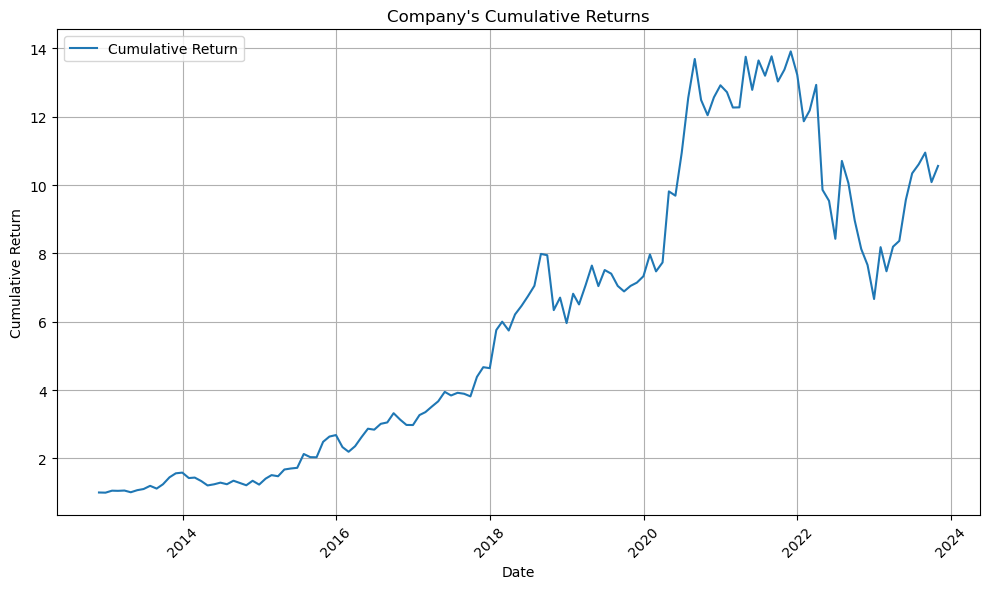

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have your data in a DataFrame called `out`
# Filter the data for the specific company (e.g., Apple)
comp = out[out['comnam'].str.contains(company_name, case=False)]
comp = comp.sort_values(by='date')

print(comp['stock_return'].describe())
print(comp['stock_return'].max())
print(comp['stock_return'].min())

# Calculate cumulative returns starting at 1
comp['cumulative_return'] = (1 + comp['stock_return']).cumprod()
comp['cumulative_return'] = comp['cumulative_return'] /  comp['cumulative_return'].iloc[0]

# Plot cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(comp['date'], comp['cumulative_return'], label='Cumulative Return')
plt.title("Company's Cumulative Returns")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


# Backtesting

Using the cash_hedged_returns as a signal of whether or not to take a position based on 
the previous X (X = lookback_period) months of cash_hedged_return performance. Works.

In [80]:
def backtest_portfolio(inp, lookback_months, signal='b_it'):
    """
    Backtests a portfolio strategy based on Point-in-Time data for monthly data.

    Parameters:
    - inp: DataFrame with Point-in-Time financial data.
        - Must contain columns: 'date', 'comnam', signal, 'stock_return', 'stock_price'.
    - lookback_months: Number of months to look back to calculate positions and weights.
    - signal: The column representing the performance signal for each company.

    Returns:
    - DataFrame with portfolio returns for each available trading month.
    - DataFrame with portfolio weights for each company and date.
    """
    data = inp.copy()
    data = data.sort_values(['comnam', 'date']).reset_index(drop=True)
    grouped = data.groupby('comnam')

    portfolio_returns = []
    portfolio_weights = []

    unique_dates = sorted(data['date'].unique())

    for current_date in unique_dates:
        portfolio = []

        for company, group in grouped:
            # Get company data up to the current date
            company_data = group[group['date'] < current_date]
            lookback_data = company_data.tail(lookback_months)

            # Skip if there's insufficient lookback data
            if len(lookback_data) < lookback_months:
                continue

            # Calculate the signal's performance over the lookback period
            signal_performance = lookback_data[signal].mean()

            if signal_performance > 0: # threshold
                # Get the return for the following month
                next_month_return = group.loc[group['date'] == current_date, 'stock_return']
                current_price = group.loc[group['date'] == current_date, 'stock_price']
                if not next_month_return.empty and not current_price.empty:
                    portfolio.append({
                        'company': company,
                        'weight': signal_performance,
                        'monthly_return': next_month_return.values[0],
                        'current_price': current_price.values[0]
                    })

        # Normalize weights for the portfolio
        if portfolio:
            portfolio_df = pd.DataFrame(portfolio)
            total_weight = portfolio_df['weight'].sum()
            portfolio_df['normalized_weight'] = portfolio_df['weight'] / total_weight

            # Calculate the portfolio return for the current month
            portfolio_return = (portfolio_df['normalized_weight'] * portfolio_df['monthly_return']).sum()

            # Calculate the portfolio value for the current month
            portfolio_value = (portfolio_df['normalized_weight'] * portfolio_df['current_price']).sum()

            # Store weights for the current portfolio
            for _, row in portfolio_df.iterrows():
                portfolio_weights.append({
                    'entry_date': current_date,
                    'company': row['company'],
                    'weight': row['normalized_weight'],
                    'price': row['current_price'],
                    'following_months_return': row['monthly_return']
                })
        else:
            portfolio_return = 0
            portfolio_value = 0

        # Append the portfolio return and value for the current date
        portfolio_returns.append({
            'entry_date': current_date,
            f'{signal}_portfolio_return': portfolio_return,
            f'{signal}_portfolio_value': portfolio_value
        })

    # Convert portfolio returns and weights to DataFrames
    portfolio_returns_df = pd.DataFrame(portfolio_returns)
    portfolio_weights_df = pd.DataFrame(portfolio_weights)

    return portfolio_returns_df, portfolio_weights_df


## Optimization of lookback period

This optimzation was run a couple times and averaged an output of 7. We cannot run it everytime due to computing power/time constraints as well as the fact that it is not scientific to optimize over the testing data - it is only permissable on the training data.

In [81]:
# from scipy.optimize import minimize

# signal = 'b_it'

# # Objective function to maximize Sharpe Ratio
# def objective(lookback_months, data):
#     lookback_months = int(lookback_months)  # Ensure it's an integer
#     if lookback_months < 1:
#         return -np.inf  # Penalize invalid lookback values
    
#     # Run the backtesting function with the given lookback_months
#     portfolio_returns_df = backtest_portfolio(data, lookback_months)
    
#     # Extract portfolio returns
#     portfolio_returns = portfolio_returns_df[f'{signal}_portfolio_return']
    
#     # Avoid invalid calculations
#     if portfolio_returns.empty or portfolio_returns.std() == 0:
#         return -np.inf  # Penalize for lack of variance or empty returns
    
#     # Compute Sharpe Ratio (assuming risk-free rate r_f = 0)
#     sharpe_ratio = portfolio_returns.mean() / portfolio_returns.std()
    
#     # Return negative Sharpe Ratio because we want to maximize it
#     return -sharpe_ratio

# # Bounds for lookback months
# bounds = [(1, 12)]  # Example: 1 to 12 months

# # Optimize lookback_months
# result = minimize(objective, x0=3, args=(out,), bounds=bounds, method='Powell')

# optimal_lookback_months = int(result.x)
# print(f"{signal} - optimal Lookback Months: {optimal_lookback_months}")

In [82]:
temp_1, temp_1_details = backtest_portfolio(out, signal='b_it', lookback_months=7)
# temp_2 = backtest_portfolio(out, signal='cash_hedged_return', lookback_months=7)

portfolio = pd.merge(temp_1, out[out['permno'] == out['permno'][0]], right_on='date', left_on='entry_date', how='right')

# portfolio = pd.merge(portfolio, temp_2, on='date', how='left')

portfolio['log_temp_return'] = np.log1p(portfolio['snp_return'])
portfolio['snp_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())
portfolio['snp_portfolio_value'] = portfolio['snp_cum_return'] / portfolio['snp_return'][0]

portfolio = portfolio[['entry_date', 'b_it_portfolio_value', 'b_it_portfolio_return', 'snp_return', 'snp_cum_return', 'snp_portfolio_value', 'rf_rate']].dropna()

portfolio

,entry_date,b_it_portfolio_value,b_it_portfolio_return,snp_return,snp_cum_return,snp_portfolio_value,rf_rate
0,2013-05-31,3.620325,-0.051142,0.020762,0.020762,1.000000,0.000000
1,2013-06-30,28.182054,-0.055405,-0.015001,0.005450,0.262490,0.000000
2,2013-07-31,29.338786,0.142383,0.049464,0.055183,2.657918,0.000000
3,2013-08-31,28.898903,-0.082701,-0.031301,0.022155,1.067117,0.000000
4,2013-09-30,27.029271,0.058899,0.029750,0.052564,2.531781,0.000000
...,...,...,...,...,...,...,...
122,2023-07-31,57.640515,0.006212,0.031139,1.872452,90.187382,0.004409
123,2023-08-31,51.660960,-0.197178,-0.017717,1.821560,87.736170,0.004610
124,2023-09-30,47.603888,-0.107669,-0.048720,1.684094,81.115051,0.004208
125,2023-10-31,5.110974,0.125804,-0.021980,1.625097,78.273453,0.004630


In [83]:
temp_1_details

,entry_date,company,weight,price,following_months_return
0,2000-04-30,ROANOKE GAS CO,1.000000,-1.5625,-0.042886
1,2000-05-31,ROANOKE GAS CO,1.000000,17.1250,-0.104577
2,2000-06-30,ROANOKE GAS CO,1.000000,17.6250,0.029198
3,2000-07-31,ROANOKE GAS CO,1.000000,18.2500,0.051850
4,2000-08-31,ROANOKE GAS CO,1.000000,18.5000,0.013701
...,...,...,...,...,...
81817,2023-11-30,YOU ON DEMAND HOLDINGS INC,0.000056,1.7000,-0.234235
81818,2023-11-30,ZEBRA TECHNOLOGIES CORP,0.000006,236.9800,0.131547
81819,2023-11-30,ZENECA GROUP PLC,0.000003,64.5900,0.021507
81820,2023-11-30,ZILLOW GROUP INC,0.000019,40.9400,0.129377


 ## Performance Analysis

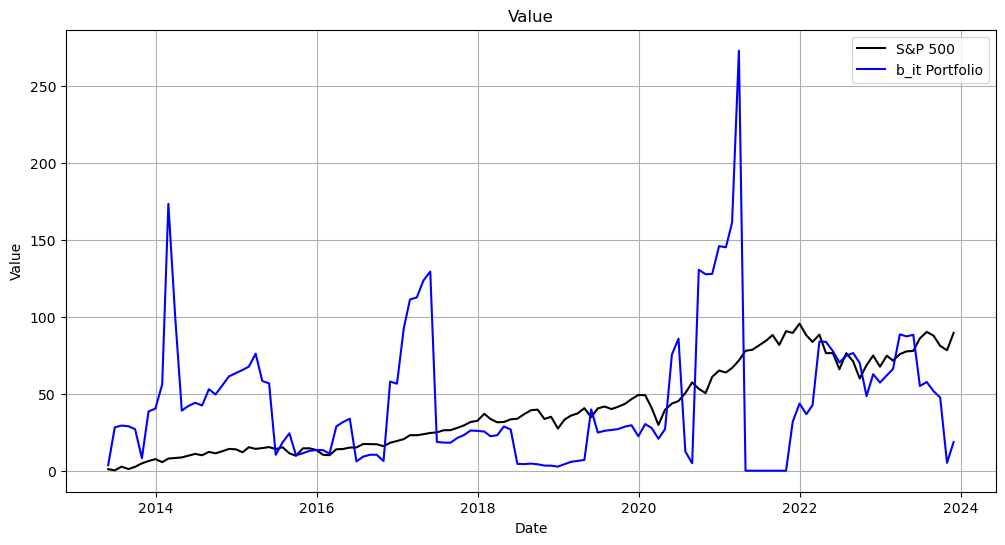

In [84]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio['entry_date'], portfolio['snp_portfolio_value'], label='S&P 500', color='black')
plt.plot(portfolio['entry_date'], portfolio['b_it_portfolio_value'], label='b_it Portfolio', color='blue')
plt.title('Value')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.show()

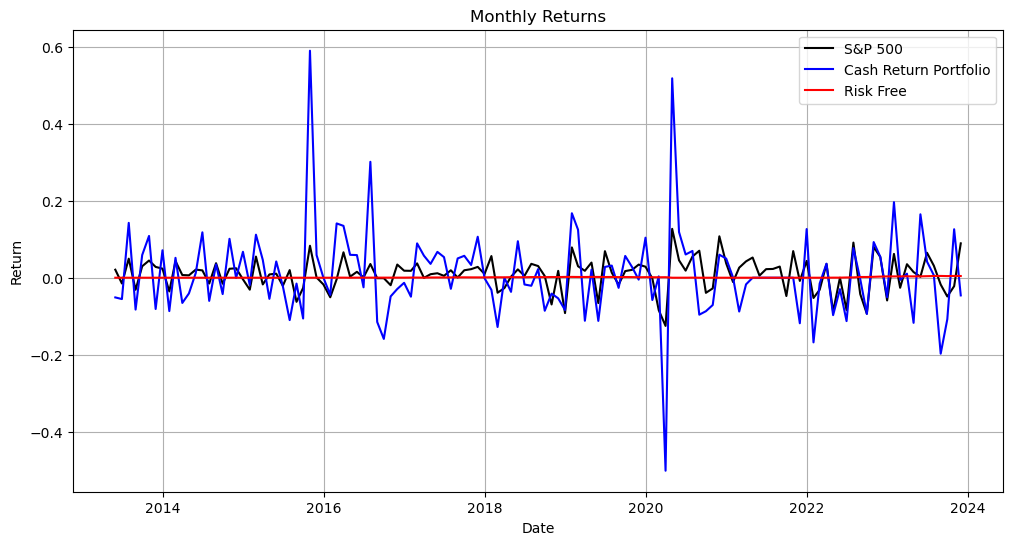

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio['entry_date'], portfolio['snp_return'], label='S&P 500', color='black')
plt.plot(portfolio['entry_date'], portfolio['b_it_portfolio_return'], label='Cash Return Portfolio', color='blue')
# plt.plot(portfolio['date'], portfolio['cash_hedged_return_portfolio_return'], label='CHR Portfolio', color='green')
plt.plot(portfolio['entry_date'], portfolio['rf_rate'], label='Risk Free', color='red')
plt.title('Monthly Returns')
plt.xlabel('Date')
plt.ylabel('Return')
plt.legend()
plt.grid()
plt.show()

In [86]:
portfolio['log_temp_return'] = np.log1p(portfolio['b_it_portfolio_return'])
portfolio['b_it_portfolio_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())

# portfolio['log_temp_return'] = np.log1p(portfolio['cash_hedged_return_portfolio_return'])
# portfolio['cash_hedged_return_portfolio_cum_return'] = np.expm1(portfolio['log_temp_return'].cumsum())

# portfolio['cash_hedged_return_portfolio_cum_return'] = (1 + portfolio['cash_hedged_return_portfolio_return']).cumprod() - 1
# portfolio['b_it_portfolio_cum_return'] = (1 + portfolio['b_it_portfolio_return']).cumprod() - 1

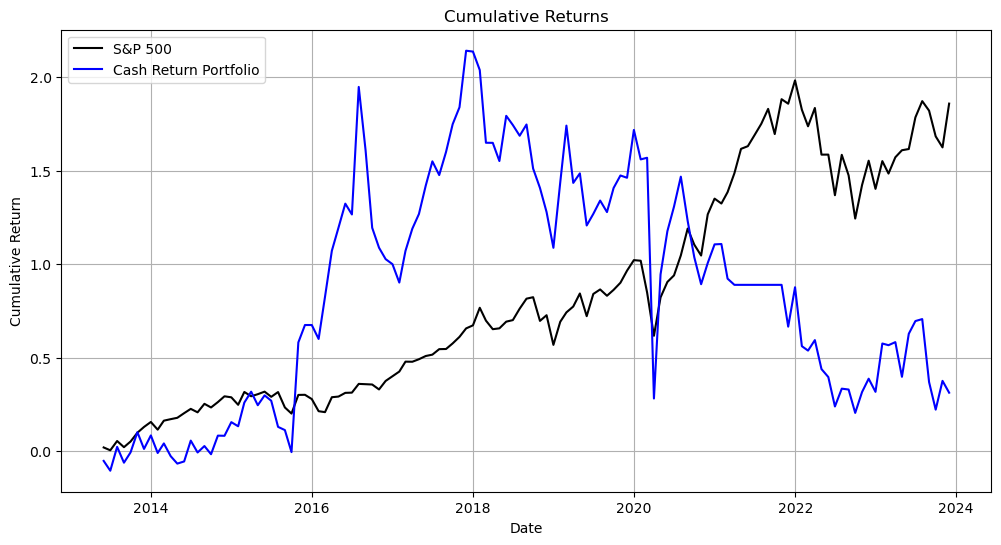

In [87]:
plt.figure(figsize=(12, 6))
plt.plot(portfolio['entry_date'], portfolio['snp_cum_return'], label='S&P 500', color='black')
plt.plot(portfolio['entry_date'], portfolio['b_it_portfolio_cum_return'], label='Cash Return Portfolio', color='blue')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

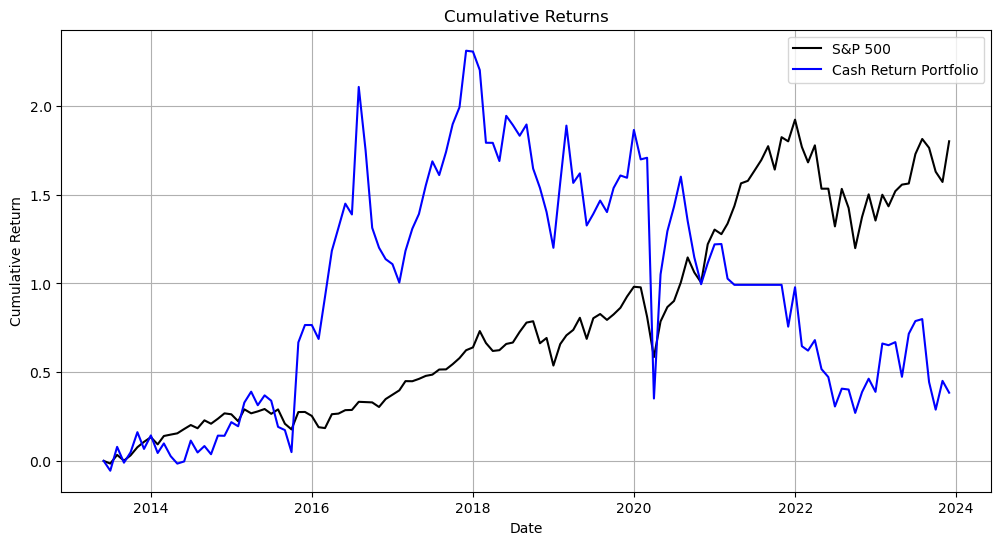

In [88]:
import matplotlib.pyplot as plt

# Assuming the original cumulative return columns are in 'portfolio'
# Add 1 to the returns, normalize to 1 by dividing by the first value, then subtract 1
portfolio['normalized_snp_cum_return'] = (portfolio['snp_cum_return'] + 1) / (portfolio['snp_cum_return'].iloc[0] + 1) - 1
portfolio['normalized_b_it_portfolio_cum_return'] = (portfolio['b_it_portfolio_cum_return'] + 1) / (portfolio['b_it_portfolio_cum_return'].iloc[0] + 1) - 1

# Plot the normalized cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(portfolio['entry_date'], portfolio['normalized_snp_cum_return'], label='S&P 500', color='black')
plt.plot(portfolio['entry_date'], portfolio['normalized_b_it_portfolio_cum_return'], label='Cash Return Portfolio', color='blue')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()


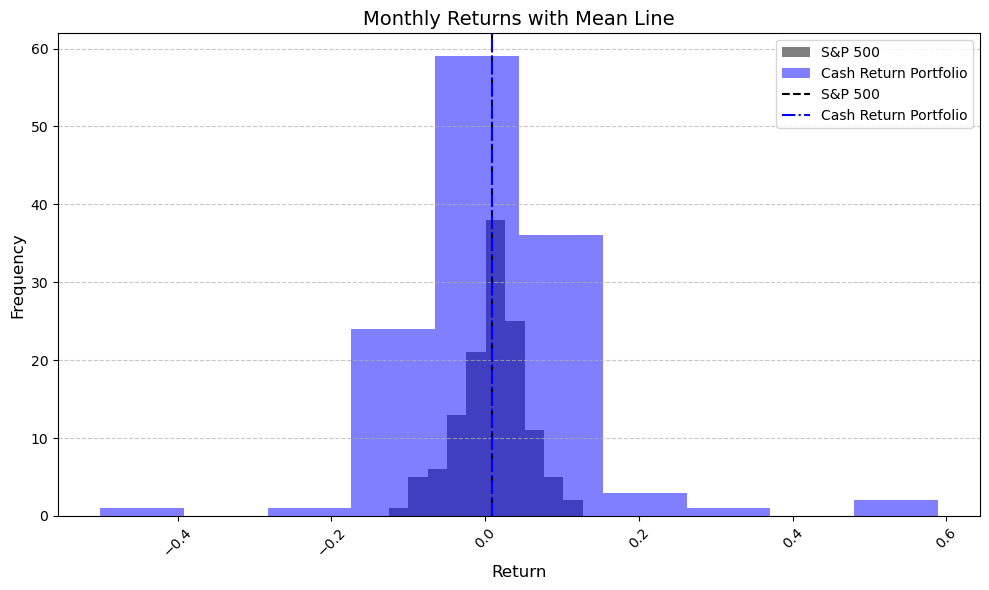

In [89]:
plt.figure(figsize=(10, 6))

plt.hist(portfolio['snp_return'], label='S&P 500', color='black', alpha=0.5)
plt.hist(portfolio['b_it_portfolio_return'], label='Cash Return Portfolio', color='blue', alpha=0.5)
# plt.hist(portfolio['cash_hedged_return_portfolio_return'], label='CHR Portfolio', color='green', alpha=0.5)

plt.axvline(portfolio["snp_return"].mean(), color="black", linestyle="--", label=f"S&P 500")
plt.axvline(portfolio["b_it_portfolio_return"].mean(), color="blue", linestyle="-.", label=f'Cash Return Portfolio')
# plt.axvline(portfolio["cash_hedged_return_portfolio_return"].mean(), color="green", linestyle="-.", label=f'CHR Portfolio')

plt.title("Monthly Returns with Mean Line", fontsize=14)
plt.xlabel("Return", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
#plt.ylim(0, 80)
plt.show()

In [61]:
def sharpe(ret):
    excess_ret = portfolio[f"{ret}"] - portfolio["rf_rate"]
    average_excess_return = excess_ret.mean()
    std_excess_return = excess_ret.std()
    return (average_excess_return / std_excess_return) * np.sqrt(12)

print("ANNUALISED:")

pd.DataFrame(
    [
        ["SNP500" , '{0:.4f}'.format(sharpe('snp_return')), (1 + portfolio['snp_return'].mean()) ** 12 - 1, (1 + (portfolio['snp_return'].std()**2)) ** 12 - 1],
        ["Cash Return Portfolio" , '{0:.4f}'.format(sharpe('b_it_portfolio_return')), (1 + portfolio['b_it_portfolio_return'].mean()) ** 12 - 1, (1 + (portfolio['b_it_portfolio_return'].std()**2)) ** 12 - 1]
        # ["CHR Portfolio" , '{0:.4f}'.format(sharpe('cash_hedged_return_portfolio_return')), (1 + portfolio['cash_hedged_return_portfolio_return'].mean()) ** 12 - 1, (1 + (portfolio['cash_hedged_return_portfolio_return'].std()**2)) ** 12 - 1],
    ],
    columns=['Asset', 'SHARPE', 'Mean Return', 'Volatility']
)

ANNUALISED:


,Asset,SHARPE,Mean Return,Volatility
0,SNP500,0.6716,0.116534,0.022438
1,Cash Return Portfolio,0.2336,0.109535,0.173666


### Pulling Nasdaq Values and Comparing with Nasdaq Growth

In [92]:
# NASDAQ VALUES

query='''
SELECT ncrtrn, caldt
FROM crsp.msio;
'''
nasdaq = conn.raw_sql(query)

nasdaq['caldt'] = pd.to_datetime(nasdaq['caldt'])

# Filter data to start from 2000 (if the full dataset were available)
#nasdaq = nasdaq[nasdaq['caldt'] >= '1990-01-01']

# rename ncrtrn to snp_return and caldt to date
nasdaq.rename(columns={'ncrtrn': 'nasdaq_return', 'caldt': 'date'}, inplace=True)
nasdaq.rename(columns={'date': 'entry_date'}, inplace=True)
nasdaq

,nasdaq_return,entry_date
0,NaN,1925-12-31
1,NaN,1926-01-30
2,NaN,1926-02-27
3,NaN,1926-03-31
4,NaN,1926-04-30
...,...,...
1172,-0.021682,2023-08-31
1173,-0.058116,2023-09-29
1174,-0.027844,2023-10-31
1175,0.106992,2023-11-30


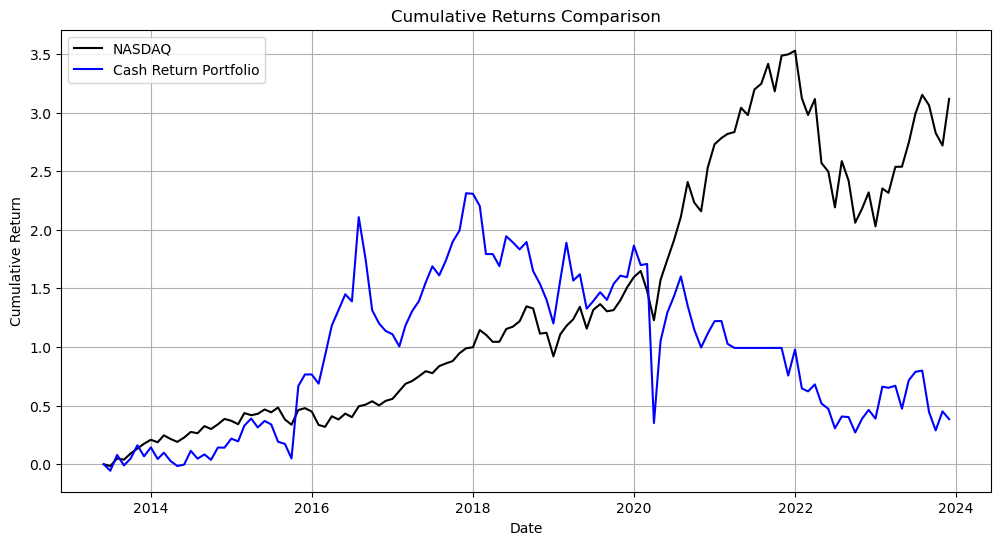

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Align nasdaq data with portfolio's entry_date using nearest date
nasdaq_aligned = pd.merge_asof(portfolio.sort_values('entry_date'),
                               nasdaq.sort_values('entry_date'),
                               left_on='entry_date',
                               right_on='entry_date',
                               direction='backward')

# Step 2: Calculate cumulative returns for nasdaq from the start date
nasdaq_aligned['nasdaq_cum_return'] = (1 + nasdaq_aligned['nasdaq_return'].fillna(0)).cumprod() - 1

# Step 3: Interpolate missing NASDAQ cumulative returns
nasdaq_aligned['nasdaq_cum_return'] = nasdaq_aligned['nasdaq_cum_return'].interpolate()

# Step 4: Normalize cumulative returns
nasdaq_aligned['normalized_nasdaq_cum_return'] = ((nasdaq_aligned['nasdaq_cum_return'] + 1) /
                                                  (nasdaq_aligned['nasdaq_cum_return'].iloc[0] + 1)) - 1
nasdaq_aligned['normalized_b_it_portfolio_cum_return'] = ((nasdaq_aligned['b_it_portfolio_return'] + 1).cumprod() /
                                                          ((nasdaq_aligned['b_it_portfolio_return'] + 1).cumprod().iloc[0])) - 1

# Step 5: Plot the cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(nasdaq_aligned['entry_date'], nasdaq_aligned['normalized_nasdaq_cum_return'], label='NASDAQ', color='black')
plt.plot(nasdaq_aligned['entry_date'], nasdaq_aligned['normalized_b_it_portfolio_cum_return'], label='Cash Return Portfolio', color='blue')
plt.title('Cumulative Returns Comparison')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()




# Correlation Calculation

In [ ]:
input_table = out[['date', 'gvkey',  'stock_return', 'b_it', 'cash_hedged_return']]
input_table = input_table.sort_values(by=['date'])
# remove any date where b_it or cash_hedged_return is NaN
input_table = input_table.dropna(subset=['b_it', 'cash_hedged_return', 'stock_return'])
# only keep one row per combination of date and gvkey
input_table = input_table.drop_duplicates(subset=['date', 'gvkey'], keep='first')
len(input_table)
input_table[:5]

,date,gvkey,stock_return,b_it,cash_hedged_return
128013,1999-09-30,009171,-0.003127,0.003132,-0.003173
128014,1999-10-31,009171,0.067510,-0.022954,0.068176
128015,1999-11-30,009171,-0.005953,-0.022439,-0.005832
128016,1999-12-31,009171,0.053892,-0.069159,0.054797
128017,2000-01-31,009171,-0.009928,0.023240,-0.010172


In [ ]:
import pandas as pd
import numpy as np
import random

def compute_random_correlations(data, compute_on='stock_return', num_iterations=1000):
    """
    Compute pairwise correlations between two randomly chosen companies over time, 
    based on stock returns or cash returns, a specified number of times.

    Parameters:
    - data (pd.DataFrame): A DataFrame with columns ['date', 'cash_return', 'stock_return', 'gvkey'].
    - compute_on (str): Column to compute correlations on ('stock_return', 'cash_return', or 'cash_hedged_return').
    - num_iterations (int): Number of random pairs to compute correlations for.

    Returns:
    - correlations (list): A list of computed correlation values.
    """

    # Pivot data for the chosen column (stock_return, cash_return, or cash_hedged_return)
    pivot_data = data.pivot(index='date', columns='gvkey', values=compute_on)

    # Drop rows with all NaN values
    pivot_data = pivot_data.dropna(how='all')

    # print(pivot_data)

    # List of unique companies (gvkeys)
    companies = pivot_data.columns.tolist()

    # print(companies)

    # Initialize a list to store correlation results
    correlations = []

    # Perform random pair correlation computation
    for _ in range(num_iterations):
        # Randomly choose two different companies
        company1, company2 = random.sample(companies, 2)

        # Extract their returns
        series1 = pivot_data[company1]
        series2 = pivot_data[company2]

        # print(series1)
        # print(series2)

        # Align the two series by index (date) and drop rows with NaN
        aligned_series = pd.concat([series1, series2], axis=1).dropna()

        # Compute the correlation if there is sufficient data
        if len(aligned_series) > 1:  # Correlation requires at least two data points
            correlation = aligned_series.corr().iloc[0, 1]  # Correlation between company1 and company2
            correlations.append(correlation)

    return correlations

# Compute correlations based on stock returns
stock_correlations = compute_random_correlations(input_table, compute_on='stock_return', num_iterations=10000)
stock_correlations = [c for c in stock_correlations if pd.notnull(c)]
print(len(stock_correlations))

# Compute correlations based on cash returns
cash_correlations = compute_random_correlations(input_table, compute_on='b_it', num_iterations=10000)
cash_correlations = [c for c in cash_correlations if pd.notnull(c)]
print(len(cash_correlations))

# Compute correlations based on cash-hedged returns
cash_hedged_correlations = compute_random_correlations(input_table, compute_on='cash_hedged_return', num_iterations=10000)
cash_hedged_correlations = [c for c in cash_hedged_correlations if pd.notnull(c)]
print(len(cash_hedged_correlations))

# Display summary statistics
print(f"Stock Return Correlation - Mean: {np.mean(stock_correlations):.3f}, Std Dev: {np.std(stock_correlations):.3f}")
print(f"Cash Return Correlation - Mean: {np.mean(cash_correlations):.3f}, Std Dev: {np.std(cash_correlations):.3f}")
print(f"Cash Hedged Return Correlation - Mean: {np.mean(cash_hedged_correlations):.3f}, Std Dev: {np.std(cash_hedged_correlations):.3f}")


6840
7482
7544
Stock Return Correlation - Mean: 0.132, Std Dev: 0.269
Cash Return Correlation - Mean: 0.023, Std Dev: 0.318
Cash Hedged Return Correlation - Mean: 0.062, Std Dev: 0.281


In [ ]:
import pandas as pd
import numpy as np

def compute_overall_correlation(data, compute_on='stock_return'):
    """
    Compute the overall average pairwise correlation across all companies based on the specified return type.

    Parameters:
    - data (pd.DataFrame): A DataFrame with columns ['date', 'cash_return', 'stock_return', 'gvkey'].
    - compute_on (str): Column to compute correlations on ('stock_return', 'cash_return', or 'cash_hedged_return').

    Returns:
    - avg_correlation (float): The average pairwise correlation across all companies.
    - std_dev_correlation (float): The standard deviation of the pairwise correlations.
    """

    # Pivot data for the chosen column (stock_return, cash_return, or cash_hedged_return)
    pivot_data = data.pivot(index='date', columns='gvkey', values=compute_on)

    # Drop rows with all NaN values
    pivot_data = pivot_data.dropna(how='all')

    # Compute the pairwise correlation matrix
    correlation_matrix = pivot_data.corr()

    # Extract the upper triangle of the correlation matrix (excluding the diagonal)
    upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

    # Flatten the upper triangle into a 1D array and drop NaN values
    pairwise_correlations = upper_triangle.unstack().dropna()

    # Compute the mean and standard deviation of the correlations
    avg_correlation = pairwise_correlations.mean()
    std_dev_correlation = pairwise_correlations.std()

    return avg_correlation, std_dev_correlation

# Compute overall correlations for stock returns
stock_avg_corr, stock_std_corr = compute_overall_correlation(input_table, compute_on='stock_return')

# Compute overall correlations for cash returns
cash_avg_corr, cash_std_corr = compute_overall_correlation(input_table, compute_on='b_it')

# Compute overall correlations for cash-hedged returns
cash_hedged_avg_corr, cash_hedged_std_corr = compute_overall_correlation(input_table, compute_on='cash_hedged_return')

# Display summary statistics
print(f"Stock Return Correlation - Mean: {stock_avg_corr:.3f}, Std Dev: {stock_std_corr:.3f}")
print(f"Cash Return Correlation - Mean: {cash_avg_corr:.3f}, Std Dev: {cash_std_corr:.3f}")
print(f"Cash Hedged Return Correlation - Mean: {cash_hedged_avg_corr:.3f}, Std Dev: {cash_hedged_std_corr:.3f}")

Stock Return Correlation - Mean: 0.132, Std Dev: 0.272
Cash Return Correlation - Mean: 0.021, Std Dev: 0.322
Cash Hedged Return Correlation - Mean: 0.067, Std Dev: 0.284


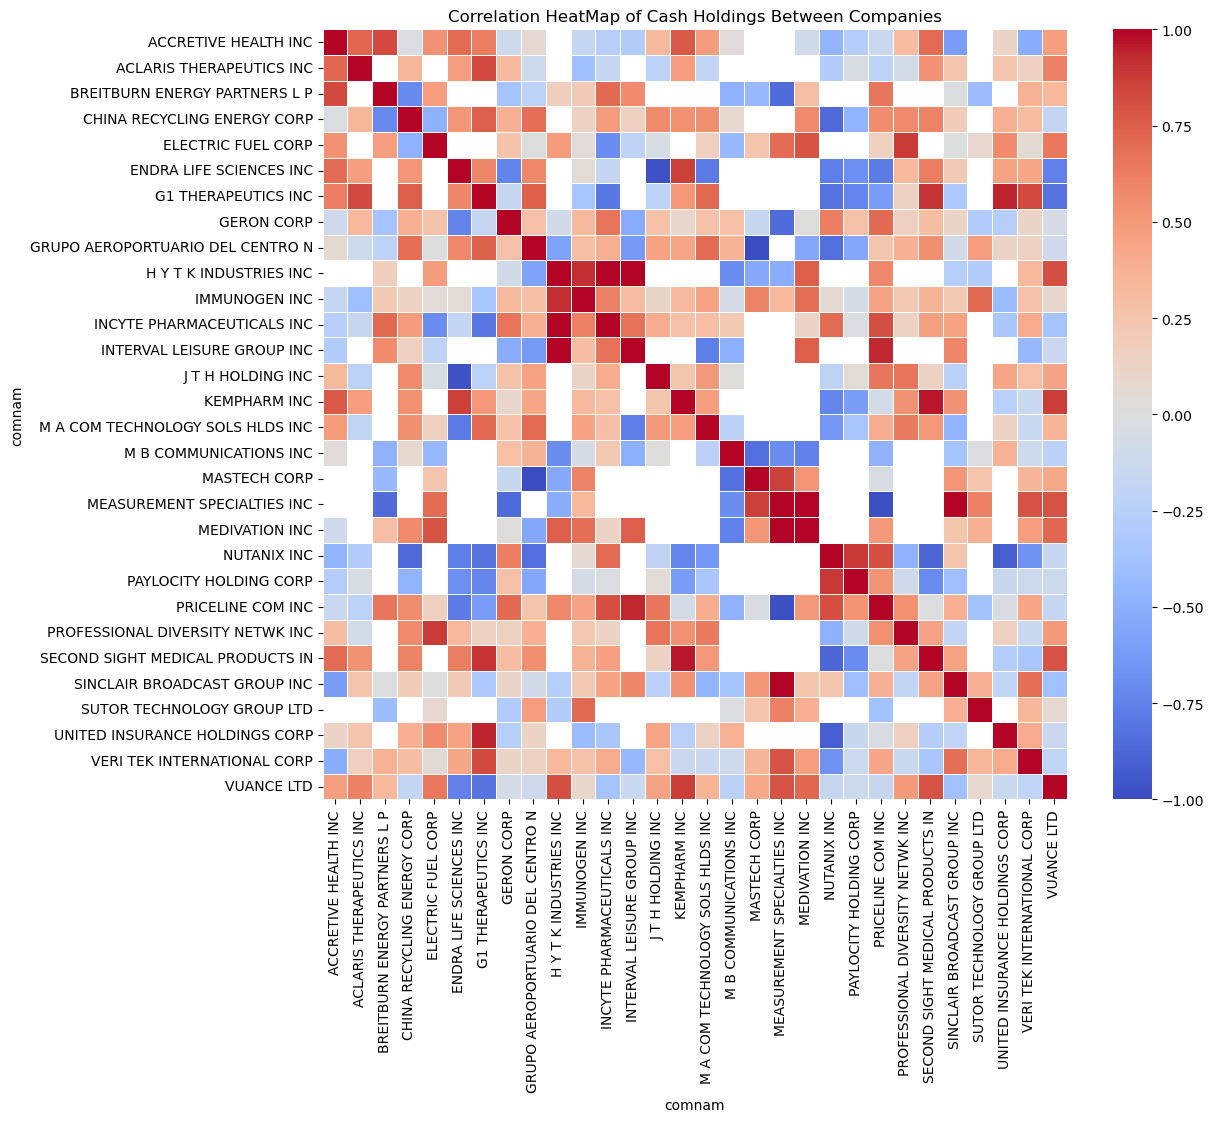

Best Seed: 83
Highest Average Correlation Between Companies: 0.17


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


# get rid of companies with constant cash holdings from out
df = out.groupby('gvkey').filter(lambda x: x['cash_holdings_t_minus_1'].nunique() > 1)


# Set the number of companies to randomly select
n = 30  # Adjust this as needed

# Initialize variables to store the best result
best_avg_correlation = -np.inf
best_seed = None
best_correlation_matrix = None

# Loop over different random seeds
for seed in range(100):  # Try 100 different random seeds
    # Select n random companies using the current seed
    selected_companies = df['comnam'].drop_duplicates().sample(n=n, random_state=seed).tolist()

    # Filter the DataFrame for the selected companies
    filtered_df = df[df['comnam'].isin(selected_companies)]

    # Create a pivot table where rows are dates, columns are companies, and values are cash_holdings_t_minus_1
    pivot = filtered_df.pivot_table(index='date', columns='comnam', values='cash_holdings_t_minus_1')

    # Compute the correlation matrix
    correlation_matrix = pivot.corr()

    # Calculate the average correlation (excluding self-correlations)
    avg_correlation = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool)).mean().mean()

    # Update the best result if this one is better
    if avg_correlation > best_avg_correlation:
        best_avg_correlation = avg_correlation
        best_seed = seed
        best_correlation_matrix = correlation_matrix

# Plot the heatmap for the best result
plt.figure(figsize=(12, 10))
sns.heatmap(best_correlation_matrix, annot=False, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title(f"Correlation HeatMap of Cash Holdings Between Companies")
plt.show()

# Print the highest average correlation and the seed that achieved it
print(f"Best Seed: {best_seed}")
print(f"Highest Average Correlation Between Companies: {best_avg_correlation:.2f}")


In [ ]:
# look at company eltek ltd in out
df[df['comnam'].str.contains('eltek ltd', case=False)]


,date,comnam,gvkey,permno,stock_price,stock_return,b_it,cash_hedged_return,snp_return,rf_rate,company_beta,cash_hedged_beta,cash_holdings_t_minus_1
51377,2013-01-31,ELTEK LTD,064278,84419.0,-1.230,0.118183,-0.105915,0.133196,0.050425,0.000000,1.016845,1.186645,1.434
51378,2013-02-28,ELTEK LTD,064278,84419.0,1.180,-0.040651,0.043165,-0.046266,0.011062,0.000000,1.006372,1.173898,1.434
51379,2013-03-31,ELTEK LTD,064278,84419.0,1.205,0.105931,-0.021032,0.114437,0.035990,0.000000,0.992133,1.162535,1.434
51380,2013-04-30,ELTEK LTD,064278,84419.0,1.230,-0.057472,-0.020305,-0.059962,0.018084,0.000000,0.978765,1.148241,1.434
51381,2013-05-31,ELTEK LTD,064278,84419.0,-1.185,-0.036584,0.347168,-0.071100,0.020762,0.000000,1.025323,1.200658,1.434
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51504,2023-07-31,ELTEK LTD,064278,84419.0,8.160,-0.127271,0.147457,-0.194096,0.031139,0.004409,-1.496567,-0.123998,8.059
51505,2023-08-31,ELTEK LTD,064278,84419.0,8.260,0.012254,-0.229228,0.072961,-0.017717,0.004610,-1.497169,-0.125528,8.059
51506,2023-09-30,ELTEK LTD,064278,84419.0,8.820,0.146488,-0.065616,0.199811,-0.048720,0.004208,-1.495057,-0.183550,8.330
51507,2023-10-31,ELTEK LTD,064278,84419.0,9.380,-0.009500,-0.059539,0.003080,-0.021980,0.004630,-1.484757,-0.196744,8.330


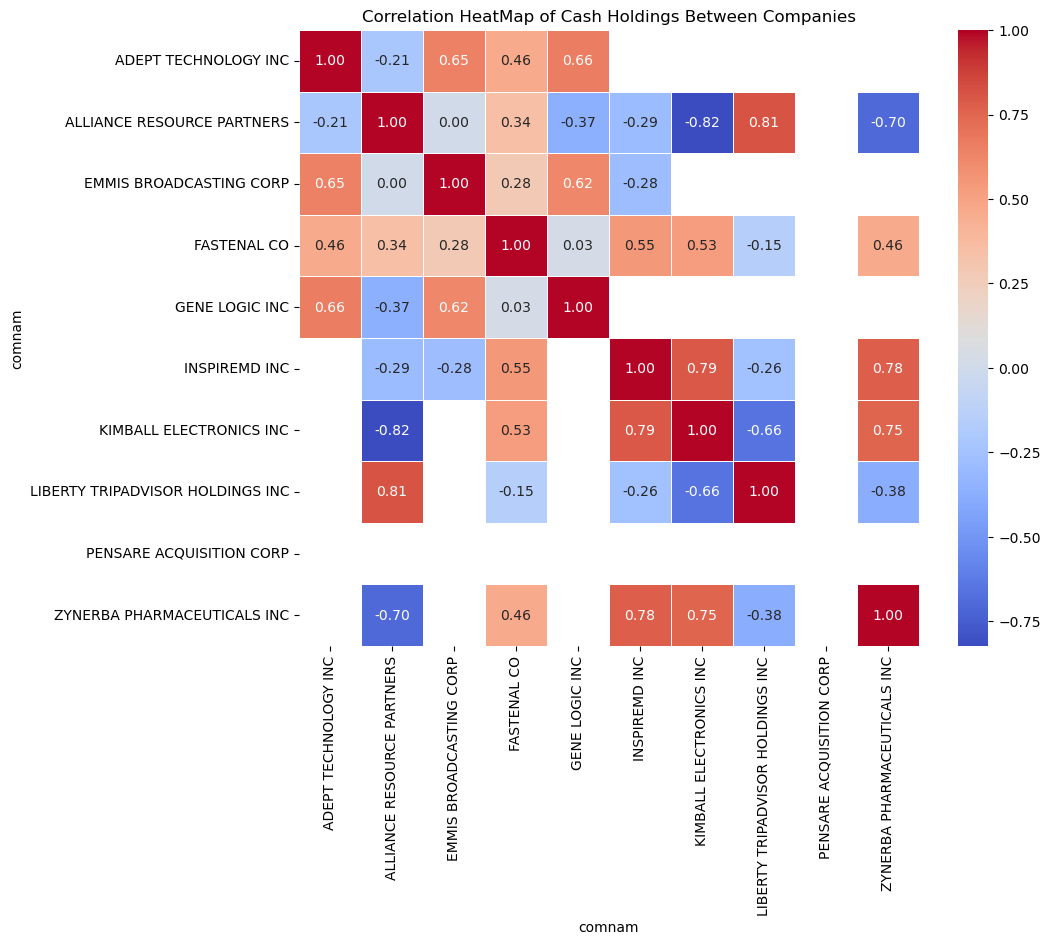

In [ ]:
df = out

# Set the number of companies to randomly select
n = 10  # Adjust this as needed

# Select n random companies
selected_companies = df['comnam'].drop_duplicates().sample(n=n, random_state=42).tolist()

# Filter the DataFrame for the selected companies
filtered_df = df[df['comnam'].isin(selected_companies)]

# Create a pivot table where rows are dates, columns are companies, and values are b_it
pivot = filtered_df.pivot_table(index='date', columns='comnam', values='cash_holdings_t_minus_1')

# Compute the correlation matrix
correlation_matrix = pivot.corr()

# Plot the HeatMap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation HeatMap of Cash Holdings Between Companies")
plt.show()
